<a href="https://colab.research.google.com/github/viki-m13/QRSC-Strategy/blob/main/QRSC_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

UNIVERSE_MODE             : ETFS
Benchmark                 : SPY
Trading days per year     : 252
USE_UNDERPERFORMERS_ONLY : False


/tmp/ipython-input-892033730.py:136: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=START_DATE, end=END_DATE, progress=False)



Using ALL assets in universe:
['XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY', 'VOO', 'VTI', 'QQQ', 'IWM', 'EFA', 'EEM', 'VEA', 'VWO', 'VXUS', 'VNQ', 'IYR', 'GLD', 'IAU', 'SLV', 'DBC']

Final tradable universe (26 tickers):
['XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY', 'VOO', 'VTI', 'QQQ', 'IWM', 'EFA', 'EEM', 'VEA', 'VWO', 'VXUS', 'VNQ', 'IYR', 'GLD', 'IAU', 'SLV', 'DBC']

QRSC stats: {'start': '2018-09-18', 'end': '2025-11-14', 'CAGR': np.float64(0.1888477833881117), 'ann_vol': 0.20649106188797023, 'Sharpe': np.float64(0.9145566963599097), 'max_dd': -0.20580844397666953, 'total_ret': np.float64(2.442819137888288), 'n_days': 1801}
SPY stats: {'start': '2018-09-18', 'end': '2025-11-14', 'CAGR': np.float64(0.1431315730986047), 'ann_vol': 0.20006941752672375, 'Sharpe': np.float64(0.7154095556832731), 'max_dd': -0.3371725510474566, 'total_ret': np.float64(1.601378466517433), 'n_days': 1801}


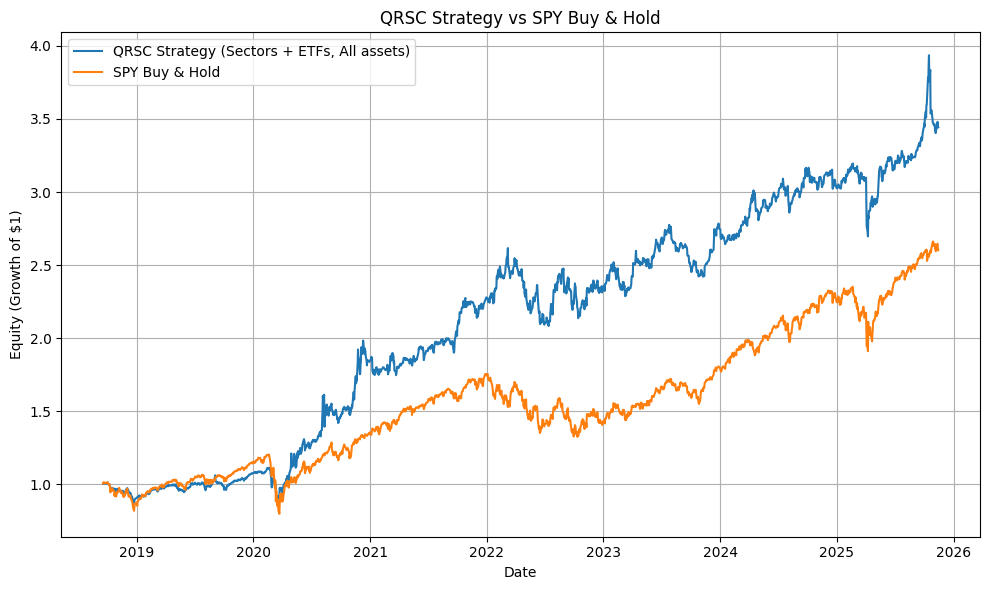

In [31]:
#!/usr/bin/env python3
import math
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ========= Config =========

# Default equity benchmark
DEFAULT_EQUITY_BENCH = "SPY"
CRYPTO_BENCH        = "BTC-USD"

START_DATE   = "2010-01-01"
END_DATE     = None  # latest

# --- Universe mode ---
#   "SECTORS" : SPDR sector ETFs only
#   "ETFS"    : sectors + extra ETFs (incl. global, style, etc.)
#   "STOCKS"  : large-cap stock list
#   "CRYPTO"  : crypto only (vs BTC-USD)
#   "ALL"     : sectors + ETFs + stocks + crypto
UNIVERSE_MODE = "ETFS"   # "SECTORS" | "ETFS" | "STOCKS" | "CRYPTO" | "ALL"

# Use only underperformers vs benchmark (SPY or BTC-USD) over full sample
USE_UNDERPERFORMERS_ONLY = False  # True = only assets that underperformed benchmark

# Sector ETFs
SECTOR_TICKERS = [
    "XLB","XLC","XLE","XLF","XLI","XLK","XLP","XLRE","XLU","XLV","XLY"
]

# Extra ETFs beyond sectors
EXTRA_ETF_TICKERS = [
    # Broad US equity / style
    "VOO", "VTI", "QQQ", "IWM",
    # International equity
    "EFA", "EEM", "VEA", "VWO", "VXUS",
    # Real estate
    "VNQ", "IYR",
    # Commodities / precious metals
    "GLD", "IAU", "SLV", "DBC",
]

# Large-cap stocks
STOCK_TICKERS = [
    # Tech
    "AAPL", "MSFT", "GOOGL", "GOOG", "META", "NVDA", "INTC", "CSCO", "ORCL",
    "ADBE", "IBM", "TXN", "AVGO", "QCOM", "AMD", "AMAT",
    # Financials
    "JPM", "BAC", "WFC", "C", "MS", "GS", "USB", "PNC", "AXP", "BLK",
    # Consumer Staples / Discretionary
    "KO", "PEP", "MCD", "SBUX", "PG", "WMT", "COST", "TGT", "NKE",
    # Healthcare
    "JNJ", "PFE", "MRK", "ABBV", "LLY", "UNH", "ABT", "TMO", "BMY",
    # Industrials
    "BA", "CAT", "MMM", "HON", "GE", "LMT", "UNP", "UPS", "FDX",
    # Energy / Materials
    "XOM", "CVX", "COP", "SLB", "EOG", "PSX", "CLF", "NEM",
    # Utilities / REITs
    "NEE", "DUK", "SO", "D", "O", "PLD", "SPG",
    # Telecom / Media
    "T", "VZ", "CMCSA",
]

# Crypto tickers (from yfinance)
CRYPTO_TICKERS = [
    "BTC-USD", "ETH-USD"
]

# QRSC params
L_LOOKBACK = 63   # days for quadratic fit
LAMBDA     = 4.0  # convexity weight
ETA        = 2.0  # softmax temperature


# ========= Helpers for benchmark & universe =========

def get_benchmark_ticker():
    """Use SPY normally, BTC-USD when in CRYPTO mode."""
    if UNIVERSE_MODE == "CRYPTO":
        return CRYPTO_BENCH
    return DEFAULT_EQUITY_BENCH


def get_trading_days_per_year():
    """Use 252 for traditional markets, 365 for crypto."""
    if UNIVERSE_MODE == "CRYPTO":
        return 365
    return 252


def get_universe_tickers(bench_ticker):
    """
    Return the list of asset tickers for the chosen UNIVERSE_MODE,
    excluding the benchmark from the tradable set.
    """
    if UNIVERSE_MODE == "SECTORS":
        tickers = SECTOR_TICKERS
    elif UNIVERSE_MODE == "ETFS":
        tickers = SECTOR_TICKERS + EXTRA_ETF_TICKERS
    elif UNIVERSE_MODE == "STOCKS":
        tickers = STOCK_TICKERS
    elif UNIVERSE_MODE == "CRYPTO":
        tickers = CRYPTO_TICKERS
    elif UNIVERSE_MODE == "ALL":
        tickers = SECTOR_TICKERS + EXTRA_ETF_TICKERS + STOCK_TICKERS + CRYPTO_TICKERS
    else:
        raise ValueError(f"Unknown UNIVERSE_MODE: {UNIVERSE_MODE}")

    # Deduplicate while preserving order
    tickers = list(dict.fromkeys(tickers))

    # Remove benchmark from tradable universe if present
    if bench_ticker in tickers:
        tickers.remove(bench_ticker)

    if not tickers:
        raise ValueError("Universe is empty after removing benchmark.")

    return tickers


# ========= Data download + prep =========

def download_data(bench_ticker):
    """
    Download Close prices for:
      - tradable universe (per UNIVERSE_MODE)
      - benchmark (SPY or BTC-USD)
    """
    asset_tickers = get_universe_tickers(bench_ticker)
    tickers = asset_tickers + [bench_ticker]
    tickers = list(dict.fromkeys(tickers))

    data = yf.download(tickers, start=START_DATE, end=END_DATE, progress=False)

    if "Close" not in data.columns:
        raise ValueError("Expected 'Close' in yfinance output columns.")

    adj = data["Close"].copy()
    adj = adj.dropna(how="all").dropna(axis=1, how="all")  # drop all-NaN cols

    missing = [t for t in tickers if t not in adj.columns]
    if missing:
        raise ValueError(f"Missing tickers in downloaded data: {missing}")

    return adj


def prepare_data(adj, bench_ticker):
    """
    1) Compute returns for all assets in the universe + benchmark.
    2) Optionally filter to underperformers vs benchmark over full sample.
    3) Build clean price / return matrices for:
         - chosen assets
         - benchmark
         - log-relative prices vs benchmark
    """
    asset_tickers = get_universe_tickers(bench_ticker)

    # Full-sample returns for universe + benchmark
    rets = adj.pct_change().dropna()
    rets_assets_full = rets[asset_tickers]
    rets_bench_full  = rets[bench_ticker]

    # Underperformer filter (in-sample selection vs benchmark)
    cum_assets   = (1.0 + rets_assets_full).cumprod().iloc[-1]
    cum_bench_end = (1.0 + rets_bench_full).cumprod().iloc[-1]

    if USE_UNDERPERFORMERS_ONLY:
        underperf = list(cum_assets[cum_assets < cum_bench_end].index)
        if not underperf:
            print("WARNING: No assets underperformed benchmark over the sample. Falling back to ALL assets.")
            chosen_tickers = asset_tickers
        else:
            chosen_tickers = underperf
            print("\nUsing ONLY underperforming assets vs benchmark:")
            print(chosen_tickers)
    else:
        chosen_tickers = asset_tickers
        print("\nUsing ALL assets in universe:")
        print(chosen_tickers)

    # Now rebuild clean price matrices for chosen_tickers + benchmark
    prices_assets = adj[chosen_tickers].dropna(how="any")
    bench = adj[bench_ticker].reindex(prices_assets.index).dropna()

    prices_assets = prices_assets.loc[bench.index]
    bench = bench.loc[prices_assets.index]

    # Daily returns (aligned)
    rets_assets = prices_assets.pct_change().fillna(0.0)
    rets_bench  = bench.pct_change().fillna(0.0)

    # Log-relative prices vs benchmark
    rel = prices_assets.div(bench, axis=0)
    log_rel = np.log(rel)

    return prices_assets, bench, rets_assets, rets_bench, log_rel, chosen_tickers


# ========= QRSC backtest =========

def backtest_QRSC(log_rel, rets_assets, rets_bench, L=63, lam=2.0, eta=4.0):
    """
    QRSC strategy backtest:
      - For each day t (after warm-up of L days):
          * Look back L days of log-relative prices.
          * Fit a quadratic curve in time for each asset.
          * Score = slope + lam * convexity.
          * Softmax(scores) → weights.
          * Apply weights to next day's asset returns to get portfolio return.
      - Rebalances DAILY (weights change every trading day after warm-up).
    """
    dates = log_rel.index

    # Precompute LS matrices for quadratic fit
    s = np.linspace(0, 1, L)
    X = np.column_stack([np.ones(L), s, 0.5 * s**2])  # basis: [1, s, 0.5 s^2]
    XtX_inv = np.linalg.inv(X.T @ X)
    Xt = X.T

    n = len(dates)
    port_rets = np.zeros(n)

    for t_idx in range(L - 1, n - 1):
        # Window of log-relative values: shape (L x N)
        window = log_rel.iloc[t_idx - L + 1 : t_idx + 1]
        Y = window.values  # L x N

        # LS quadratic coefficients (3 x N)
        Beta = XtX_inv @ (Xt @ Y)
        beta1 = Beta[1, :]  # slope
        beta2 = Beta[2, :]  # convexity

        # QRSC score
        scores = beta1 + lam * beta2

        # Center cross-sectionally
        scores_c = scores - scores.mean()

        # Softmax -> weights
        w = np.exp(eta * scores_c)
        w_sum = w.sum()
        if w_sum == 0 or not np.isfinite(w_sum):
            continue
        w /= w_sum

        # Next-day realized asset returns
        next_rets = rets_assets.iloc[t_idx + 1].values  # length N
        port_rets[t_idx + 1] = np.dot(w, next_rets)

    # Build Series
    port_series = pd.Series(port_rets, index=dates, name="QRSC")

    # Trim pre-start flat section (pre-warmup)
    nonzero_idx = np.where(port_series.values != 0)[0]
    if len(nonzero_idx) == 0:
        raise RuntimeError("No active period in backtest.")
    start = nonzero_idx[0]
    port_series = port_series.iloc[start:]

    bench_series = rets_bench.reindex(port_series.index)

    return port_series, bench_series


# ========= Performance stats =========

def perf_stats(r, trading_days_per_year):
    eq = (1 + r).cumprod()
    ann_ret = eq.iloc[-1] ** (trading_days_per_year / len(r)) - 1
    ann_vol = r.std() * math.sqrt(trading_days_per_year)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else float("nan")
    peak = eq.cummax()
    dd = eq / peak - 1
    max_dd = dd.min()
    return {
        "start": str(r.index[0].date()),
        "end": str(r.index[-1].date()),
        "CAGR": ann_ret,
        "ann_vol": ann_vol,
        "Sharpe": sharpe,
        "max_dd": max_dd,
        "total_ret": eq.iloc[-1] - 1,
        "n_days": len(r),
    }


# ========= Main =========

def main():
    bench_ticker = get_benchmark_ticker()
    trading_days_per_year = get_trading_days_per_year()

    print(f"UNIVERSE_MODE             : {UNIVERSE_MODE}")
    print(f"Benchmark                 : {bench_ticker}")
    print(f"Trading days per year     : {trading_days_per_year}")
    print(f"USE_UNDERPERFORMERS_ONLY : {USE_UNDERPERFORMERS_ONLY}")

    adj = download_data(bench_ticker)
    prices_assets, bench, rets_assets, rets_bench, log_rel, chosen_tickers = prepare_data(adj, bench_ticker)

    print(f"\nFinal tradable universe ({len(chosen_tickers)} tickers):")
    print(chosen_tickers)

    qrsc_rets, bench_rets = backtest_QRSC(
        log_rel,
        rets_assets,
        rets_bench,
        L=L_LOOKBACK,
        lam=LAMBDA,
        eta=ETA,
    )

    stats_q = perf_stats(qrsc_rets, trading_days_per_year)
    stats_b = perf_stats(bench_rets, trading_days_per_year)

    print("\nQRSC stats:", stats_q)
    print(f"{bench_ticker} stats:", stats_b)

    # Plot equity curves
    eq_q = (1 + qrsc_rets).cumprod()
    eq_b = (1 + bench_rets).cumprod()

    # Human-readable label for universe
    if UNIVERSE_MODE == "SECTORS":
        universe_label = "Sectors only"
    elif UNIVERSE_MODE == "ETFS":
        universe_label = "Sectors + ETFs"
    elif UNIVERSE_MODE == "STOCKS":
        universe_label = "Stocks only"
    elif UNIVERSE_MODE == "CRYPTO":
        universe_label = "Crypto only"
    else:
        universe_label = "All assets"

    perf_label = "Underperformers only" if USE_UNDERPERFORMERS_ONLY else "All assets"

    plt.figure(figsize=(10, 6))
    plt.plot(eq_q.index, eq_q.values,
             label=f"QRSC Strategy ({universe_label}, {perf_label})")
    plt.plot(eq_b.index, eq_b.values, label=f"{bench_ticker} Buy & Hold")
    plt.xlabel("Date")
    plt.ylabel("Equity (Growth of $1)")
    plt.title(f"QRSC Strategy vs {bench_ticker} Buy & Hold")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


#Walk Forward CV Optimization

UNIVERSE_MODE             : ALL
Benchmark                 : SPY
Trading days per year     : 252
USE_UNDERPERFORMERS_ONLY : False


/tmp/ipython-input-505749632.py:152: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=START_DATE, end=END_DATE, progress=False)
/tmp/ipython-input-505749632.py:179: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = adj.pct_change().dropna()



Using ALL assets in universe:
['XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY', 'VOO', 'VTI', 'QQQ', 'IWM', 'EFA', 'EEM', 'VEA', 'VWO', 'VXUS', 'VNQ', 'IYR', 'GLD', 'IAU', 'SLV', 'DBC', 'AAPL', 'MSFT', 'GOOGL', 'GOOG', 'META', 'NVDA', 'INTC', 'CSCO', 'ORCL', 'ADBE', 'IBM', 'TXN', 'AVGO', 'QCOM', 'AMD', 'AMAT', 'JPM', 'BAC', 'WFC', 'C', 'MS', 'GS', 'USB', 'PNC', 'AXP', 'BLK', 'KO', 'PEP', 'MCD', 'SBUX', 'PG', 'WMT', 'COST', 'TGT', 'NKE', 'JNJ', 'PFE', 'MRK', 'ABBV', 'LLY', 'UNH', 'ABT', 'TMO', 'BMY', 'BA', 'CAT', 'MMM', 'HON', 'GE', 'LMT', 'UNP', 'UPS', 'FDX', 'XOM', 'CVX', 'COP', 'SLB', 'EOG', 'PSX', 'CLF', 'NEM', 'NEE', 'DUK', 'SO', 'D', 'O', 'PLD', 'SPG', 'T', 'VZ', 'CMCSA', 'BTC-USD', 'ETH-USD']

Final tradable universe (99 tickers):
['XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY', 'VOO', 'VTI', 'QQQ', 'IWM', 'EFA', 'EEM', 'VEA', 'VWO', 'VXUS', 'VNQ', 'IYR', 'GLD', 'IAU', 'SLV', 'DBC', 'AAPL', 'MSFT', 'GOOGL', 'GOOG', 'META

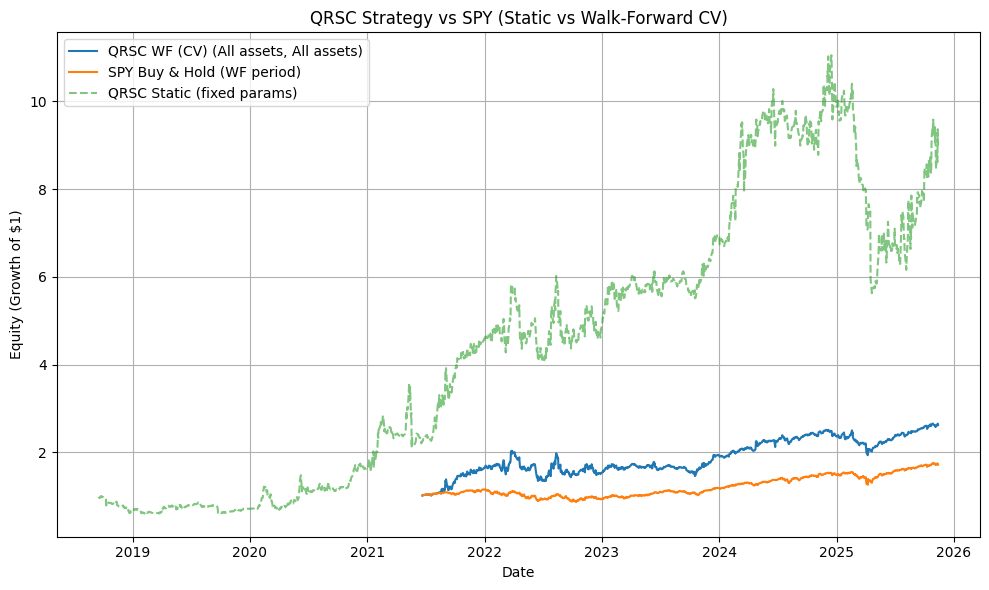

In [20]:
#!/usr/bin/env python3
import math
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from collections import Counter

# ========= Config =========

# Default equity benchmark
DEFAULT_EQUITY_BENCH = "SPY"
CRYPTO_BENCH        = "BTC-USD"

START_DATE   = "2010-01-01"
END_DATE     = None  # latest

# --- Universe mode ---
#   "SECTORS" : SPDR sector ETFs only
#   "ETFS"    : sectors + extra ETFs (incl. global, style, etc.)
#   "STOCKS"  : large-cap stock list
#   "CRYPTO"  : crypto only (vs BTC-USD)
#   "ALL"     : sectors + ETFs + stocks + crypto
UNIVERSE_MODE = "ALL"   # "SECTORS" | "ETFS" | "STOCKS" | "CRYPTO" | "ALL"

# Use only underperformers vs benchmark (SPY or BTC-USD) over full sample
USE_UNDERPERFORMERS_ONLY = False  # True = only assets that underperformed benchmark

# Sector ETFs
SECTOR_TICKERS = [
    "XLB","XLC","XLE","XLF","XLI","XLK","XLP","XLRE","XLU","XLV","XLY"
]

# Extra ETFs beyond sectors
EXTRA_ETF_TICKERS = [
    # Broad US equity / style
    "VOO", "VTI", "QQQ", "IWM",
    # International equity
    "EFA", "EEM", "VEA", "VWO", "VXUS",
    # Real estate
    "VNQ", "IYR",
    # Commodities / precious metals
    "GLD", "IAU", "SLV", "DBC",
]

# Large-cap stocks
STOCK_TICKERS = [
    # Tech
    "AAPL", "MSFT", "GOOGL", "GOOG", "META", "NVDA", "INTC", "CSCO", "ORCL",
    "ADBE", "IBM", "TXN", "AVGO", "QCOM", "AMD", "AMAT",
    # Financials
    "JPM", "BAC", "WFC", "C", "MS", "GS", "USB", "PNC", "AXP", "BLK",
    # Consumer Staples / Discretionary
    "KO", "PEP", "MCD", "SBUX", "PG", "WMT", "COST", "TGT", "NKE",
    # Healthcare
    "JNJ", "PFE", "MRK", "ABBV", "LLY", "UNH", "ABT", "TMO", "BMY",
    # Industrials
    "BA", "CAT", "MMM", "HON", "GE", "LMT", "UNP", "UPS", "FDX",
    # Energy / Materials
    "XOM", "CVX", "COP", "SLB", "EOG", "PSX", "CLF", "NEM",
    # Utilities / REITs
    "NEE", "DUK", "SO", "D", "O", "PLD", "SPG",
    # Telecom / Media
    "T", "VZ", "CMCSA"
]

# Crypto tickers (from yfinance)
CRYPTO_TICKERS = [
    "BTC-USD", "ETH-USD"
]

# Baseline QRSC params (for static reference run)
L_LOOKBACK = 63   # days for quadratic fit
LAMBDA     = 3.0  # convexity weight
ETA        = 2.0  # softmax temperature

# --- Walk-forward CV settings ---

# Fixed L for QRSC; we only tune (lambda, eta) here.
WF_L_LOOKBACK = 63

# Rolling window length for parameter selection
TRAIN_WINDOW_DAYS   = 252 * 3   # ~3 years
VALIDATION_DAYS     = 63        # last 63 days of train window used for scoring
REBALANCE_FREQ_DAYS = 21        # re-choose parameters every ~1 month

# Grid of (lambda, eta) to test in each training window
LAMBDA_GRID = [1.0, 2.0, 3.0, 4.0]
ETA_GRID    = [1.0, 2.0, 3.0]
PARAM_GRID  = [(lam, eta) for lam in LAMBDA_GRID for eta in ETA_GRID]


# ========= Helpers for benchmark & universe =========

def get_benchmark_ticker():
    """Use SPY normally, BTC-USD when in CRYPTO mode."""
    if UNIVERSE_MODE == "CRYPTO":
        return CRYPTO_BENCH
    return DEFAULT_EQUITY_BENCH


def get_trading_days_per_year():
    """Use 252 for traditional markets, 365 for crypto."""
    if UNIVERSE_MODE == "CRYPTO":
        return 365
    return 252


def get_universe_tickers(bench_ticker):
    """
    Return the list of asset tickers for the chosen UNIVERSE_MODE,
    excluding the benchmark from the tradable set.
    """
    if UNIVERSE_MODE == "SECTORS":
        tickers = SECTOR_TICKERS
    elif UNIVERSE_MODE == "ETFS":
        tickers = SECTOR_TICKERS + EXTRA_ETF_TICKERS
    elif UNIVERSE_MODE == "STOCKS":
        tickers = STOCK_TICKERS
    elif UNIVERSE_MODE == "CRYPTO":
        tickers = CRYPTO_TICKERS
    elif UNIVERSE_MODE == "ALL":
        tickers = SECTOR_TICKERS + EXTRA_ETF_TICKERS + STOCK_TICKERS + CRYPTO_TICKERS
    else:
        raise ValueError(f"Unknown UNIVERSE_MODE: {UNIVERSE_MODE}")

    # Deduplicate while preserving order
    tickers = list(dict.fromkeys(tickers))

    # Remove benchmark from tradable universe if present
    if bench_ticker in tickers:
        tickers.remove(bench_ticker)

    if not tickers:
        raise ValueError("Universe is empty after removing benchmark.")

    return tickers


# ========= Data download + prep =========

def download_data(bench_ticker):
    """
    Download Close prices for:
      - tradable universe (per UNIVERSE_MODE)
      - benchmark (SPY or BTC-USD)
    """
    asset_tickers = get_universe_tickers(bench_ticker)
    tickers = asset_tickers + [bench_ticker]
    tickers = list(dict.fromkeys(tickers))

    data = yf.download(tickers, start=START_DATE, end=END_DATE, progress=False)

    if "Close" not in data.columns:
        raise ValueError("Expected 'Close' in yfinance output columns.")

    adj = data["Close"].copy()
    adj = adj.dropna(how="all").dropna(axis=1, how="all")  # drop all-NaN cols

    missing = [t for t in tickers if t not in adj.columns]
    if missing:
        raise ValueError(f"Missing tickers in downloaded data: {missing}")

    return adj


def prepare_data(adj, bench_ticker):
    """
    1) Compute returns for all assets in the universe + benchmark.
    2) Optionally filter to underperformers vs benchmark over full sample.
    3) Build clean price / return matrices for:
         - chosen assets
         - benchmark
         - log-relative prices vs benchmark
    """
    asset_tickers = get_universe_tickers(bench_ticker)

    # Full-sample returns for universe + benchmark
    rets = adj.pct_change().dropna()
    rets_assets_full = rets[asset_tickers]
    rets_bench_full  = rets[bench_ticker]

    # Underperformer filter (in-sample selection vs benchmark)
    cum_assets    = (1.0 + rets_assets_full).cumprod().iloc[-1]
    cum_bench_end = (1.0 + rets_bench_full).cumprod().iloc[-1]

    if USE_UNDERPERFORMERS_ONLY:
        underperf = list(cum_assets[cum_assets < cum_bench_end].index)
        if not underperf:
            print("WARNING: No assets underperformed benchmark over the sample. Falling back to ALL assets.")
            chosen_tickers = asset_tickers
        else:
            chosen_tickers = underperf
            print("\nUsing ONLY underperforming assets vs benchmark:")
            print(chosen_tickers)
    else:
        chosen_tickers = asset_tickers
        print("\nUsing ALL assets in universe:")
        print(chosen_tickers)

    # Now rebuild clean price matrices for chosen_tickers + benchmark
    prices_assets = adj[chosen_tickers].dropna(how="any")
    bench = adj[bench_ticker].reindex(prices_assets.index).dropna()

    prices_assets = prices_assets.loc[bench.index]
    bench = bench.loc[prices_assets.index]

    # Daily returns (aligned)
    rets_assets = prices_assets.pct_change().fillna(0.0)
    rets_bench  = bench.pct_change().fillna(0.0)

    # Log-relative prices vs benchmark
    rel = prices_assets.div(bench, axis=0)
    log_rel = np.log(rel)

    return prices_assets, bench, rets_assets, rets_bench, log_rel, chosen_tickers


# ========= QRSC core (returns only, no trimming) =========

def qrsc_returns(log_rel, rets_assets, L, lam, eta):
    """
    Compute daily QRSC portfolio returns on the given data:
      - For each day t (after warm-up of L days):
          * Look back L days of log-relative prices.
          * Fit a quadratic curve in time for each asset.
          * Score = slope + lam * convexity.
          * Softmax(scores) → weights.
          * Apply weights to next day's asset returns to get portfolio return.
      - Returns a Series aligned with log_rel.index.
      - Pre-warmup returns are 0.
    """
    dates = log_rel.index
    n = len(dates)
    port_rets = np.zeros(n)

    if n <= L:
        return pd.Series(port_rets, index=dates, name="QRSC")

    # Precompute LS matrices for quadratic fit
    s = np.linspace(0, 1, L)
    X = np.column_stack([np.ones(L), s, 0.5 * s**2])  # basis: [1, s, 0.5 s^2]
    XtX_inv = np.linalg.inv(X.T @ X)
    Xt = X.T

    for t_idx in range(L - 1, n - 1):
        window = log_rel.iloc[t_idx - L + 1 : t_idx + 1]
        Y = window.values  # L x N

        # LS quadratic coefficients (3 x N)
        Beta = XtX_inv @ (Xt @ Y)
        beta1 = Beta[1, :]  # slope
        beta2 = Beta[2, :]  # convexity

        # QRSC score
        scores = beta1 + lam * beta2

        # Center cross-sectionally
        scores_c = scores - scores.mean()

        # Softmax -> weights
        w = np.exp(eta * scores_c)
        w_sum = w.sum()
        if w_sum == 0 or not np.isfinite(w_sum):
            continue
        w /= w_sum

        # Next-day realized asset returns
        next_rets = rets_assets.iloc[t_idx + 1].values  # length N
        port_rets[t_idx + 1] = np.dot(w, next_rets)

    return pd.Series(port_rets, index=dates, name="QRSC")


# ========= Static QRSC backtest (for reference) =========

def backtest_QRSC_static(log_rel, rets_assets, rets_bench, L, lam, eta):
    """
    Run QRSC once over the whole sample with fixed (L, lam, eta).
    This is the original "static" backtest (daily rebal with fixed parameters).
    """
    port_series = qrsc_returns(log_rel, rets_assets, L, lam, eta)

    # Trim initial all-zero segment (pre-warmup)
    nonzero_idx = np.where(port_series.values != 0)[0]
    if len(nonzero_idx) == 0:
        raise RuntimeError("No active period in static backtest.")
    start = nonzero_idx[0]
    port_series = port_series.iloc[start:]
    bench_series = rets_bench.reindex(port_series.index)

    return port_series, bench_series


# ========= Performance stats =========

def perf_stats(r, trading_days_per_year):
    eq = (1 + r).cumprod()
    ann_ret = eq.iloc[-1] ** (trading_days_per_year / len(r)) - 1
    ann_vol = r.std() * math.sqrt(trading_days_per_year)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else float("nan")
    peak = eq.cummax()
    dd = eq / peak - 1
    max_dd = dd.min()
    return {
        "start": str(r.index[0].date()),
        "end": str(r.index[-1].date()),
        "CAGR": ann_ret,
        "ann_vol": ann_vol,
        "Sharpe": sharpe,
        "max_dd": max_dd,
        "total_ret": eq.iloc[-1] - 1,
        "n_days": len(r),
    }


def daily_sharpe(r):
    mu = r.mean()
    sigma = r.std()
    if sigma <= 0:
        return -np.inf
    return mu / sigma


# ========= Walk-forward CV for (lambda, eta) =========

def walk_forward_qrsc(log_rel, rets_assets, rets_bench):
    """
    Walk-forward parameter selection + out-of-sample trading:

      - Use a rolling training window of TRAIN_WINDOW_DAYS.
      - Inside each window, evaluate PARAM_GRID on the last VALIDATION_DAYS
        (using daily Sharpe) via qrsc_returns().
      - Pick (lambda, eta) with best validation Sharpe.
      - Apply that parameter pair out-of-sample for the next
        REBALANCE_FREQ_DAYS.
      - Repeat until the end of the sample.

    Returns:
      r_port : concatenated out-of-sample QRSC returns Series
      r_bench: aligned benchmark returns Series
      info   : dict with chosen params and rebalance dates
    """
    dates = log_rel.index
    n = len(dates)

    if n <= TRAIN_WINDOW_DAYS + WF_L_LOOKBACK:
        raise ValueError("Not enough data for the specified TRAIN_WINDOW_DAYS and WF_L_LOOKBACK.")

    segments_port = []
    segments_bench = []
    chosen_params = []
    rebal_dates = []

    # Start walk-forward after we have enough history
    rebal_ix = TRAIN_WINDOW_DAYS

    while rebal_ix < n:
        train_start_ix = rebal_ix - TRAIN_WINDOW_DAYS
        train_end_ix   = rebal_ix  # exclusive

        log_train  = log_rel.iloc[train_start_ix:train_end_ix]
        rets_train = rets_assets.iloc[train_start_ix:train_end_ix]

        best_param = None
        best_score = -np.inf

        # --- Local CV over PARAM_GRID ---
        for lam, eta in PARAM_GRID:
            port_train = qrsc_returns(log_train, rets_train, WF_L_LOOKBACK, lam, eta)

            if len(port_train) < VALIDATION_DAYS + WF_L_LOOKBACK:
                continue

            val_slice = port_train.iloc[-VALIDATION_DAYS:]
            score = daily_sharpe(val_slice)

            if score > best_score:
                best_score = score
                best_param = (lam, eta)

        if best_param is None:
            # Fallback: first param in grid, equal-weight is not appropriate here,
            # but grid includes "mild" params like (1,1).
            print(f"[{dates[rebal_ix].date()}] All parameter candidates failed; "
                  f"falling back to {PARAM_GRID[0]}.")
            best_param = PARAM_GRID[0]

        lam_best, eta_best = best_param

        # --- Out-of-sample segment ---
        trade_start_ix = rebal_ix
        trade_end_ix   = min(rebal_ix + REBALANCE_FREQ_DAYS, n)

        # For OOS returns we run QRSC on all data up to trade_end_ix with the chosen params,
        # then slice the OOS segment [trade_start_ix : trade_end_ix).
        log_sub  = log_rel.iloc[:trade_end_ix]
        rets_sub = rets_assets.iloc[:trade_end_ix]

        port_full = qrsc_returns(log_sub, rets_sub, WF_L_LOOKBACK, lam_best, eta_best)

        start_date = dates[trade_start_ix]
        end_date   = dates[trade_end_ix - 1]

        seg_port  = port_full.loc[start_date:end_date]
        seg_bench = rets_bench.loc[start_date:end_date]

        segments_port.append(seg_port)
        segments_bench.append(seg_bench)
        chosen_params.append(best_param)
        rebal_dates.append(dates[rebal_ix])

        rebal_ix += REBALANCE_FREQ_DAYS

    r_port  = pd.concat(segments_port).sort_index()
    r_bench = pd.concat(segments_bench).reindex(r_port.index)

    info = {
        "rebal_dates": rebal_dates,
        "chosen_params": chosen_params,
    }
    return r_port, r_bench, info


# ========= Main =========

def main():
    bench_ticker = get_benchmark_ticker()
    trading_days_per_year = get_trading_days_per_year()

    print(f"UNIVERSE_MODE             : {UNIVERSE_MODE}")
    print(f"Benchmark                 : {bench_ticker}")
    print(f"Trading days per year     : {trading_days_per_year}")
    print(f"USE_UNDERPERFORMERS_ONLY : {USE_UNDERPERFORMERS_ONLY}")

    adj = download_data(bench_ticker)
    prices_assets, bench, rets_assets, rets_bench, log_rel, chosen_tickers = prepare_data(adj, bench_ticker)

    print(f"\nFinal tradable universe ({len(chosen_tickers)} tickers):")
    print(chosen_tickers)

    # ===== 1. Static QRSC with fixed (L, lambda, eta) (for reference) =====
    try:
        qrsc_static, bench_static = backtest_QRSC_static(
            log_rel,
            rets_assets,
            rets_bench,
            L=L_LOOKBACK,
            lam=LAMBDA,
            eta=ETA,
        )

        stats_q_static = perf_stats(qrsc_static, trading_days_per_year)
        stats_b_static = perf_stats(bench_static, trading_days_per_year)

        print("\n=== Static QRSC (fixed params) stats ===")
        print("QRSC :", stats_q_static)
        print(f"{bench_ticker} :", stats_b_static)
    except RuntimeError as e:
        print(f"\nStatic QRSC backtest failed: {e}")
        qrsc_static = None
        bench_static = None

    # ===== 2. Walk-forward QRSC with parameter CV =====
    r_port_wf, r_bench_wf, info = walk_forward_qrsc(log_rel, rets_assets, rets_bench)

    stats_q_wf = perf_stats(r_port_wf, trading_days_per_year)
    stats_b_wf = perf_stats(r_bench_wf, trading_days_per_year)

    print("\n=== Walk-Forward QRSC (with CV over lambda, eta) stats (out-of-sample) ===")
    print("QRSC WF :", stats_q_wf)
    print(f"{bench_ticker} :", stats_b_wf)

    # Parameter usage diagnostics
    c_counter = Counter(info["chosen_params"])
    print("\n=== Chosen (lambda, eta) frequencies over rebalances ===")
    for (lam, eta), cnt in sorted(c_counter.items()):
        print(f"(lambda={lam}, eta={eta}): used {cnt} times")

    # ===== Plot equity curves =====
    # Human-readable label for universe
    if UNIVERSE_MODE == "SECTORS":
        universe_label = "Sectors only"
    elif UNIVERSE_MODE == "ETFS":
        universe_label = "Sectors + ETFs"
    elif UNIVERSE_MODE == "STOCKS":
        universe_label = "Stocks only"
    elif UNIVERSE_MODE == "CRYPTO":
        universe_label = "Crypto only"
    else:
        universe_label = "All assets"

    perf_label = "Underperformers only" if USE_UNDERPERFORMERS_ONLY else "All assets"

    plt.figure(figsize=(10, 6))
    # Walk-forward curve
    eq_q_wf = (1 + r_port_wf).cumprod()
    eq_b_wf = (1 + r_bench_wf).cumprod()
    plt.plot(eq_q_wf.index, eq_q_wf.values,
             label=f"QRSC WF (CV) ({universe_label}, {perf_label})")
    plt.plot(eq_b_wf.index, eq_b_wf.values,
             label=f"{bench_ticker} Buy & Hold (WF period)")

    # Optional: plot static run if available and overlapping
    if qrsc_static is not None:
        eq_q_static = (1 + qrsc_static).cumprod()
        plt.plot(eq_q_static.index, eq_q_static.values,
                 linestyle="--", alpha=0.6,
                 label="QRSC Static (fixed params)")

    plt.xlabel("Date")
    plt.ylabel("Equity (Growth of $1)")
    plt.title(f"QRSC Strategy vs {bench_ticker} (Static vs Walk-Forward CV)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
